In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import pickle
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [101]:
# this defines all of the default colors and markers for the plots
# keys = ['bananas/bananas', 'hb', 'ls', 'rs', 're', 'ls_svr', 'rea_svr', 'bananas_svr/bananas']
predictors = ['rs', 'sh']

# TODO: What of this am I really needing?
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0),
            (0.7058823529411765, 0.12156862745098039, 0.4666666666666667),
            (0.4666666666666667, 0.8901960784313725, 0.7607843137254902,),
           ]

fmts = ['-', '--', ':']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]

# 
pred_plot_dict={
    'ls':{'color':defaults[0], 'fmt':fmts[0]},
    # 'ls_lce':{'color':defaults[0], 'fmt':fmts[1]},
    # 'ls_svr':{'color':defaults[0], 'fmt':fmts[2]},
    # 're':{'color':defaults[1], 'fmt':fmts[0]},
    # 'rea_lce':{'color':defaults[1], 'fmt':fmts[1]},
    # 'rea_svr':{'color':defaults[1], 'fmt':fmts[2]},
    'bananas/bananas':{'color':defaults[2], 'fmt':fmts[0]},
    # 'bananas_lce/bananas':{'color':defaults[2], 'fmt':fmts[1]},
    # 'bananas_svr/bananas':{'color':defaults[2], 'fmt':fmts[2]},    
    'rs':{'color':defaults[3], 'fmt':fmts[0]},
    'sh': {'color': defaults[1], 'fmt':fmts[0]},
    'hb':{'color':defaults[4], 'fmt':fmts[0]},
    # 'bohb':{'color':defaults[5], 'fmt':fmts[0]},
    # 'dehb':{'color':defaults[6], 'fmt':fmts[0]},
}

# define colors, formats, and markers
c_max = 10
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-']*c_max, *['--']*c_max, *[':']*c_max]
markers = [*['^']*c_max, *['v']*c_max, *['o']*c_max]

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

# some of them are not used
pred_label_dict={
    'bananas/gcn':'BANANAS-GCN', 'bananas/bananas':'BANANAS', 'bananas/xgb':'BANANAS-XGB', 
    'npenas/gcn':'NPENAS-GCN', 'npenas/bananas':'NPENAS-BANANAS', 'npenas/xgb':'NPENAS-XGB', 
    'rs':'RS',
    're': 'REA',
    'ls': 'LS',
    'hb': 'HB',
    'sh': 'SH',
    'bohb': 'BOHB',
    'dehb': 'DEHB',
    'rea_svr': 'REA-SVR',
    'bananas_svr/bananas':'BANANAS-SVR',
    'rea_lce': 'REA-WPM',
    'bananas_lce/bananas':'BANANAS-WPM',
    'ls_svr': 'LS-SVR',
    'ls_lce': 'LS-WPM',
    'ls_svr_hp': 'LS-SVR-HP',
    'rea_svr_hp': 'REA-SVR-HP',
    'bananas_svr_hp/bananas': 'BANANAS-SVR-HP',
}

val_gts = {'cifar10': 91.61, 
           'cifar100': 73.49, 
           'ImageNet16-120': 46.77, 
           'nasbench311': 95.8, 
           'nasbench111':95.6, 
           'nasbenchnlp':100.7}

datasets = {'cifar10': 'cifar10',
           'cifar100': 'cifar100', 
           'ImageNet16-120': 'ImageNet16-120', 
           'nasbench311': 'cifar10', 
           'nasbench111':'cifar10', 
           'nasbenchnlp':'ptb'
           }

In [102]:
def merge_and_fill_trajectories(pandas_data_frames, default_value=None):
    # merge all trajectories keeping all time steps
    df = pd.DataFrame().join(pandas_data_frames, how='outer')

    # forward fill to make it a propper step function
    df = df.fillna(method='ffill')
    if default_value is None:
        # backward fill to replace the NaNs for the early times by the
        # performance of a random configuration
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(default_value)
    return df

In [103]:
def get_trajectories(losses, iterations):
    dfs = []
    for i in range(len(losses)):
        loss = losses[i]
        iteration = iterations[i]
        # print('Run %d, Min: %f'%(i, loss))
        df = pd.DataFrame({str(i): loss}, index=iteration)
        dfs.append(df)

    df = merge_and_fill_trajectories(dfs, default_value=None)

    return np.array(df.T), np.array(df.index)

In [104]:
def get_results(predictor, path, metric='valid_acc', key_choice=None):
    output = []
    time = []
    nan_count = 0
    missing_results_count = 0
    file_count = 0
    for folder in os.listdir(path):
        if not(folder == datasets[key_choice] and os.path.isdir(os.path.join(path, folder))):
            continue
        # TODO: This needs to be done better !!
        # Because config_0 is just one config, with multiple seed.
        # But more than one config with multiple seed should be possible. 
        algo_path = os.path.join(path, folder, predictor, 'config_0')
        if not os.path.isdir(algo_path):
            continue
        seed_dirs = list(os.listdir(algo_path))
        
        print(seed_dirs)
        # seed_dirs = sorted(seed_dirs, key=lambda x: int(x))
        seed_dirs = sorted(seed_dirs)

        for seed_dir in seed_dirs:
            '''if not os.path.isdir(os.path.join(algo_path, seed_dir)):
                continue
            result_file = os.path.join(algo_path, seed_dir, 'errors.json')

            if not (os.path.isfile(result_file) and file_count < 100):
                continue
            file_count += 1'''
            result_file = os.path.join(algo_path, seed_dir)
            result = json.load(open(result_file))                        
            # config = result[0]
            epochs = len(result[1]['train_time'])

            val_acc = result[1]['valid_acc'][:epochs]

            if key_choice == 'nasbench111':
                val_incumbent = [(val_gts[key_choice] - val_acc[0] *  100.) / 100.]
                for  ind in range(1, len(val_acc)):
                    val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind]) *100.)  / 100)
            elif key_choice == 'nasbenchnlp':
                val_incumbent = [np.exp(100 - val) - val_gts[key_choice] for val in val_acc]
            else:
                val_incumbent = [(val_gts[key_choice] - val_acc[0]) / 100]
                for ind in range(1, len(val_acc)):
                    val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind])) / 100)


            runtime = result[1]['runtime']
            train_time = result[1]['train_time']
            runtime = [sum(runtime[:epoch]) for epoch in range(1, len(runtime)+1)]
            train_time = [sum(train_time[:epoch]) for epoch in range(1, len(train_time)+1)]
            total_time = [i+j for i,j in zip(runtime, train_time)]
            if predictor == 'sh':
                total_time[:] = [x / 200.0 for x in total_time]
            # I think we should just plot validation accs, since that's what the nas algorithm uses
            if metric == 'valid_acc':
                incumbent = val_incumbent
                #incumbent = val_acc
            elif metric == 'test_acc':
                test_err = [100 - x for x in result[1]['test_acc']]
                inc_idx, best, best_idx = [], np.inf, 0
                for i, err in enumerate(val_err):
                    if err < best:
                        best, best_idx = err, i
                    inc_idx.append(best_idx)
                incumbent = [test_err[idx] for idx in inc_idx]

            if len(incumbent) == epochs:
                output.append(incumbent)
                time.append(total_time)
            else:
                nan_count += 1

    output = np.array(output)
    time = np.array(time)
    
    output, time = get_trajectories(output, time)
    
    print(predictor, 'output shape', output.shape, 'nans', nan_count, 'missing files', missing_results_count)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(np.var(output, axis=0, ddof=1)/np.asarray(output).shape[0])
    print('first mean', mean[0], 'last mean', mean[-1])
    print('first std', std[0], 'last std', std[-1])
    return mean, std, std_error, time

In [105]:
def save_results_to_dict(folder, predictors, key_choice):
    results_dict = {}
    print('\n saving', key_choice)
    for i, predictor in enumerate(predictors):
        mean, std, std_error, runtime = get_results(predictor, folder, metric='valid_acc', key_choice=key_choice)
        key = predictor
        results_dict[key] = {'label':pred_label_dict[predictor], 
                             'key':key, 'mean':mean, 'std':std, 
                             'std_error': std_error, 'runtime': runtime}
    return results_dict

In [106]:
def save_all_results():
    
    all_results = {}
     
    # that was/is very very shity code!
    key_choice = 'nasbench311'
    folder = os.path.expanduser(os.path.join(base_path, 'nasbench201'))
    all_results[key_choice] = save_results_to_dict(folder, predictors, key_choice)       
    return all_results

# Load results into dictionary

In [107]:
base_path = '/Users/lars/Projects/NASLib-mf/naslib/benchmarks/mf/run/'

results = save_all_results()


 saving nasbench311
['errors.json']
rs output shape (1, 200) nans 0 missing files 0
first mean 0.08989999999999995 last mean 0.0536999999999999
first std 0.0 last std 0.0
['errors.json']
sh output shape (1, 2953) nans 0 missing files 0
first mean 0.3997999999267578 last mean 0.04564000014648428
first std 0.0 last std 0.0


# Plotting results

In [108]:
result_folder = 'plots_naslib/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

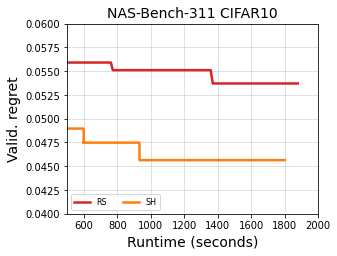

<Figure size 432x288 with 0 Axes>

In [109]:
# plot performance vs runtime

for key_choice in results.keys():
    results_dict = results[key_choice]

    keys = predictors


    keys = sorted(keys)

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = 'dotted'
    add_sub_axes = False

    fig, ax = plt.subplots(figsize=[4.5, 3.5])
    if add_sub_axes:
        sub_axes = plt.axes([.6, .5, .3, .38]) 


    for i, key in enumerate(keys):
        mean = results_dict[key]['mean']
        sem = results_dict[key]['std_error']
        label = results_dict[key]['label']
        x = results_dict[key]['runtime']
        #tag = '_'.join(key.split('_')[:-1])
        tag = key
        color = pred_plot_dict[tag]['color']
        fmt = pred_plot_dict[tag]['fmt']
        ax.plot(x, mean, label=label, color=color, linestyle=fmt, linewidth=2.5)
        ax.fill_between(x, mean-2*sem, mean+2*sem,
                        color=color, alpha=0.2)

        if add_sub_axes:
            n = 450
            X_detail = x[n:]
            Y_detail = mean[n:]
            sem_detail = sem[n:]
            sub_axes.plot(X_detail, Y_detail, color=color, linestyle=fmt)
            sub_axes.tick_params(labelbottom=False) 

    ax.set_xlabel('Runtime (seconds)', fontsize=14)

    if key_choice == 'nasbenchnlp':
        ax.set_ylabel('Perplexity regret', fontsize=14) #nas201
    else:
        ax.set_ylabel('Valid. regret', fontsize=14) #nas201

    ax.grid(True, which="both",ls="-", alpha=.5)

    if key_choice == 'cifar10':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.001, .19])
        ax.set_xlim([1e4, 4*10e4])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas201_c10.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'cifar100':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([0.002, 0.3])
        ax.set_xlim([1e4, 8.1e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 CIFAR100', fontsize=14)
        save_path = os.path.join(result_folder, 'nas201_c100.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'ImageNet16-120':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.002, .4])
        ax.set_xlim([1e4, 1.0e6])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 ImageNet16-120', fontsize=14, loc='right')
        save_path = os.path.join(result_folder, 'nas201_im.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'nasbench311':    
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.set_ylim([.04, .06])
        ax.set_xlim([500, 2000])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-311 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas311_c10.pdf')
        plt.show()
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbench111':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([4e-4, 8e-2])
        ax.set_xlim([2e4, 5.8*10e4])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-111 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas111_c10.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbenchnlp':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.5, 4.2e1])
        ax.set_xlim([5e4, 1.0*10e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-NLP11 PTB', fontsize=14)
        save_path = os.path.join(result_folder, 'nasn11_ptb.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
